# TP 4 Réseaux de neurones - Multi classification et Propagation en avant
Dans ce TP, nous aimerions faire une classification multiclasse. Pour ce faire, nous allons comparer entre une classification utilisant la regression logistique, et une classification en utilisant les réseaux de neurones.

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [ ]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données.

Mettons ces données dans leus vecteurs correspondants.

In [ ]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [ ]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

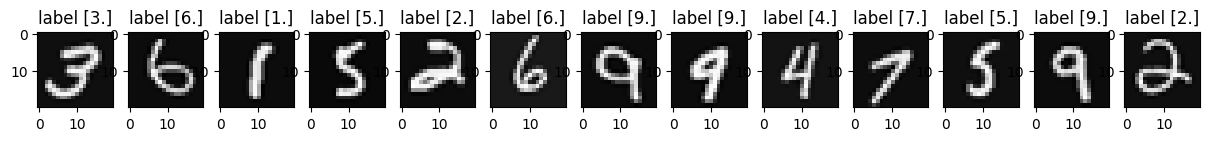

In [ ]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

# Partie 1, régression logistique
Dans cette partie, nous aimerions utiliser la régression logistique pour classifier nos images

Rappelons que la régression logistique nous donne la probabilité d'appartenance (oui ou non) à la classe 1 (elle permet une classification binaire).

Pour étendre la régression logistique à une multi-classification, nous allons utiliser une stratégie 1 contre tous.

Nos paramètres $\theta$ seront donc une matrice avec un nombre de lignes égale au nombre de classes, et avec un nombre de colones égale au nombre des caractéristiques + 1 (chaque ligne de la matrice $\theta$ correspond aux paramètres d'un classifieur.

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    sig = 1 / ( 1 + np.exp(-1*z) )
    return sig

In [ ]:
def computeCostRegulariseNonVect(X, y, theta,lamda_):
    j=0
    n = X.shape[0]  #obtenir le nombre de lignes de la matrice X, ce qui correspond au nombre d'échantillons dans l'ensemble de données.
    m = X.shape[1] #obtenir le nombre de lignes de la matrice X, ce qui correspond au nombre de caractéristiques.
    for i in range(n): #Boucle sur chaque échantillon dans l'ensemble de données
       p=0
       for i in range(m):
        p += theta[j][0] * X[i][j]
       j += y[i] * np.log(Sigmoid(p)) + (1-y[i])  * np.log( 1 - Sigmoid(p)) #la somme des difference entre la valeur predite et la valeur reel
      # ou Sigmoid(p) est la fonction h
    regularisation= np.sum(np.pow(theta[1:],2)) * (lamda_ / (2*n ))
    j = j / (-1*n)  + regularisation #la moyenne du cout
    return j

In [ ]:
def computeCostRegularise(X, y, theta,lamda_):
    n = X.shape[0]
    h = Sigmoid(np.matmul(X, theta))  # Calcul de h_theta(x)
    regularisation= np.sum(pow(theta[1:],2)) * (lamda_ / (2*n ))
    cost = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h)) + regularisation
    return cost

In [ ]:
def est_proche_de_zero(nombre, tolérance=0.00000000000001): #la tolerance est trop petite car les valeurs de cout sont trop faibles
    return abs(nombre) <= tolérance     #utilisée pour vérifier si la mise à jour des paramètres a convergé vers une solution proche de zéro, ce qui indique une convergence vers un minimum local ou global de la fonction de coût.

In [ ]:
def lrCostFunction (X, y, initial_theta, alpha, MaxIter,lambda_):
    # dans cette fonction vous devez appliquer la regression logistique avec tout les calculs nécessaires
    # calcul du coût, calcul du gradient,
    #minimisation du coût avec descente du gradient,
    #et retour des paramètres theta pour une classe
    n = X.shape[0]
    cost_list = []
    theta = initial_theta
    couti = computeCostRegularise(X, y, theta,lambda_)
    nb=MaxIter
    while True:
      d = np.zeros((X.shape[1], 1)) # pour chaque paramètre calculer la somme des dérivées
      h = Sigmoid(np.matmul(X, theta))  # Calcul des prédictions

      d =  np.dot(X.T, (h - np.reshape(y, h.shape))) / n # Calcul des dérivées

      theta_prime_list = []
      for j in range (theta.shape[0]):
        theta_prime_list.append(theta[j][0] - alpha * ( d[j][0]) + (lambda_ * theta[j][0]  /n ) )  # ou (lambda_ * theta[j][0]  /n )  est la regularisation

      for j in range (theta.shape[0]):
         theta[j][0] = theta_prime_list[j]

      coutj = computeCostRegularise(X, y, theta,lambda_)
      cost_list.append(coutj)

      nb -= 1
      if nb ==0 or est_proche_de_zero(abs(couti - coutj)): # verifier si il y a eu une convergence
        break
      else:
        couti=coutj # le préparer pour la prochaine itération

    return theta,cost_list


In [ ]:
def tracer_cout_it(cost_list):
  iterations = range(1, len(cost_list) + 1)
  # Tracer le graphe du coût en fonction du nombre d'itérations
  plt.plot(iterations, cost_list, marker='o', linestyle='-')

  plt.xlabel('Nombre d\'itérations')
  plt.ylabel('Coût')

  plt.title('Évolution du coût en fonction du nombre d\'itérations')

  plt.grid(True)

  plt.show()

In [ ]:
def predictOnveVsAll (all_theta, X):
    # ici en utilisant les paramètres calculés par la régression logisitique,
    # nous aimerions retourner les etiquettes predites

    # Ici chaque classifieur retournera une probabilité, il faudra choisir
    # la probabilité maximale pour un exemple donné
    # répeter pour tous les exmemples
    y_pred=np.zeros((X.shape[0], 1));
    for i in range(X.shape[0]): #pour chaque échantillon
      max_proba=0
      for j in range(all_theta.shape[0]): # calcul de la proba de chaque classe
        proba = Sigmoid(np.matmul(X[i][:],all_theta[j][:].T))
        if (proba > max_proba):
          max_proba=proba
          predected_calsse=j
      y_pred[i]=predected_calsse

    return y_pred

In [ ]:
classes= np.unique(y)
number_classes=classes.shape[0]
all_theta = np.zeros((number_classes, X.shape[1]));
all_theta.shape

(10, 401)

 tracage de cout pour la classe0


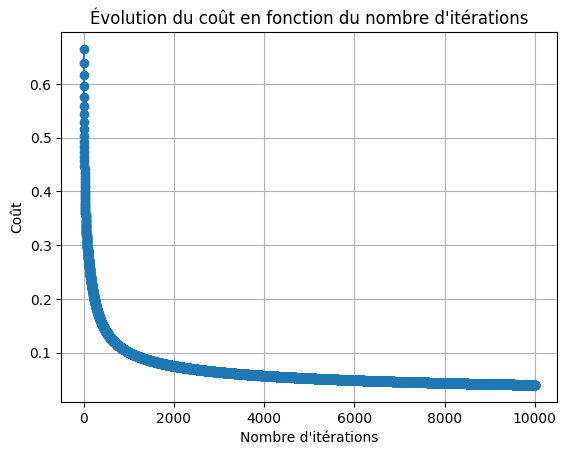

 tracage de cout pour la classe1


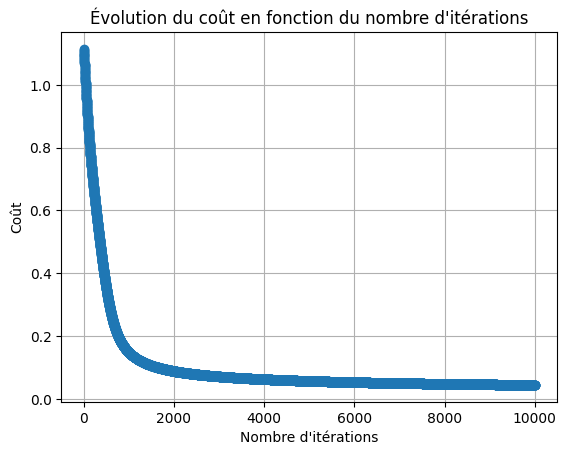

 tracage de cout pour la classe2


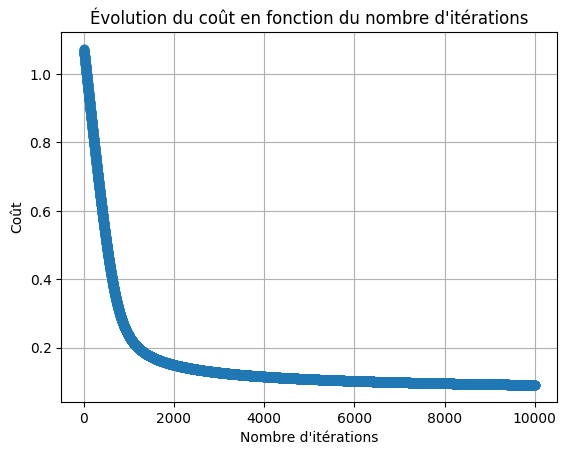

 tracage de cout pour la classe3


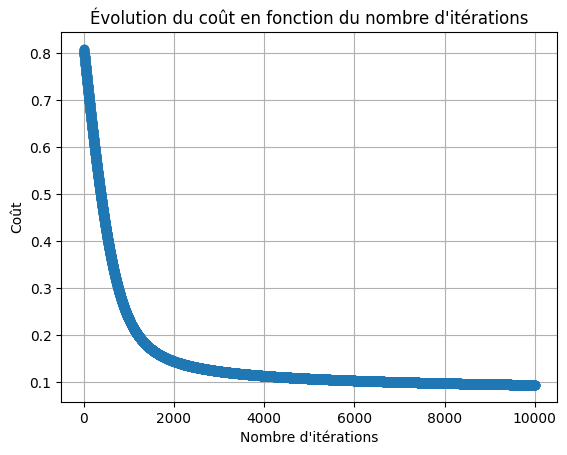

 tracage de cout pour la classe4


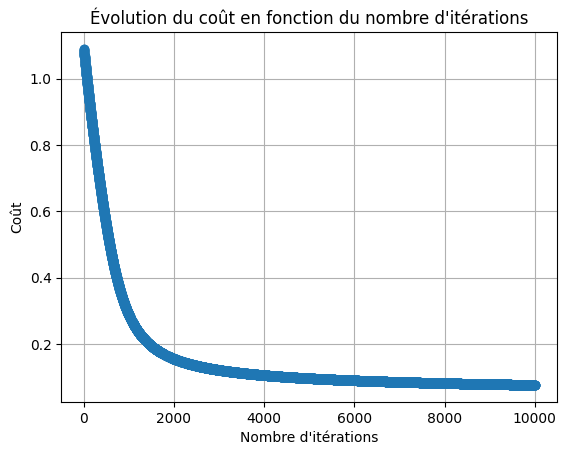

 tracage de cout pour la classe5


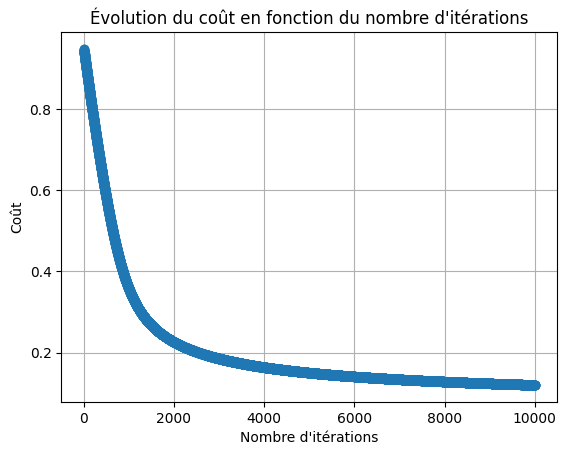

 tracage de cout pour la classe6


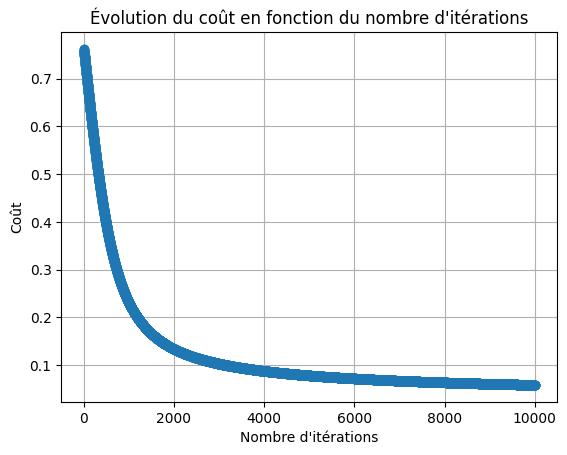

 tracage de cout pour la classe7


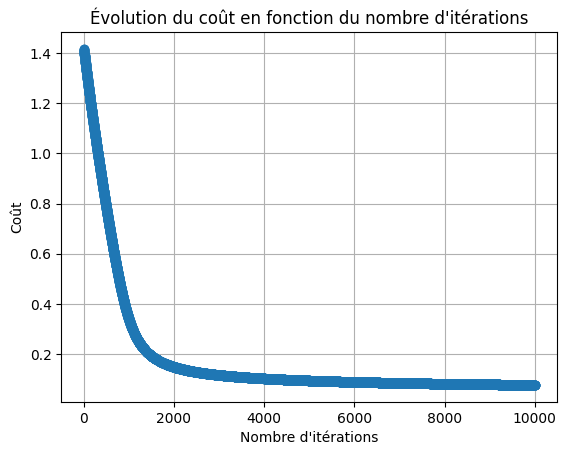

 tracage de cout pour la classe8


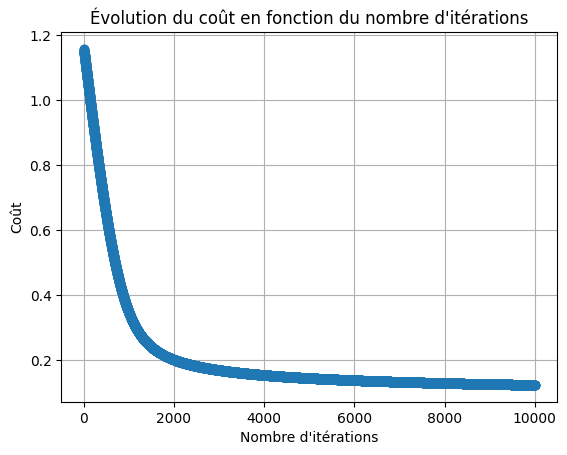

 tracage de cout pour la classe9


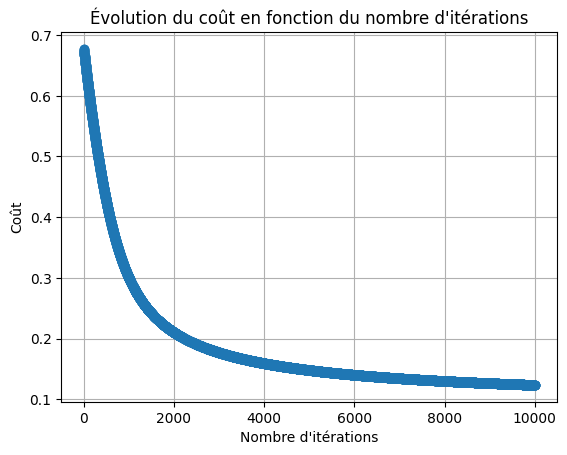

In [ ]:
MaxIter= 10000
lambda_= 0.1
alpha = 0.01
# initial_theta pour chaque classifieur
initial_theta=np.zeros((X.shape[1], 1));
for i in range (number_classes):
     # appel pour chaque classifieur
     theta, costs = lrCostFunction(X,(y==classes[i]).astype(int),initial_theta,alpha, MaxIter,lambda_);
     print(" tracage de cout pour la classe"+ str(i))
     tracer_cout_it(costs)
     theta_reshaped = theta.flatten()  # Ajustement de la forme de theta
     all_theta[i, :] = theta_reshaped

In [ ]:
y_pred = predictOnveVsAll(all_theta, X);

# Qualité du classifieur RL

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [ ]:
precision = np.mean(y==y_pred)*100
precision


88.38000000000001

# Partie 2: Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [ ]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [ ]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [ ]:
input_layer_size  = 400;
hidden_layer_size = 25;
num_labels = 10;

**Prédiction**

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [ ]:
def predict(W1, W2, X):

    # Calcul de l'activation de la couche cachée
    a1 = Sigmoid(np.matmul(X, W1.T))

    intercept = np.ones((X.shape[0], 1))
    a1_with_intercept = np.concatenate((intercept,a1), axis=1)

    # Calcul de l'activation de la couche de sortie
    a2 = Sigmoid(np.matmul(a1_with_intercept, W2.T))

    # Choix de la classe prédite
    y_pred = np.argmax(a2, axis=1)[..., np.newaxis]

    # Ajouter 1 à la prédiction car les classes commencent à 1
    y_pred = y_pred + 1
    y_pred[y_pred == 10] = 0

    return y_pred

In [ ]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(W1, W2 , X)
#print(y)
#print(y_pred)
precision = np.mean(y == y_pred)*100
precision

97.52

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


model = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), activation='logistic', solver='sgd', max_iter=10000)

# Entraîner le modèle avec les données
model.fit(X, y)

# Prédire les classes avec les données X
y_pred = model.predict(X)

# Calculer la précision
precision = accuracy_score(y, y_pred)

print("Précision du modèle : {:.2f}%".format(precision * 100))


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Précision du modèle : 93.38%


# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage